In [1]:
#importing libraries
import os
import cv2
import random
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.utils import to_categorical, plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, regularizers, optimizers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
#function to load images and extract data
img_size = 96
def load_data(path, train=True):
    print("Loading data from: ", path)
    data = []
    for img in os.listdir(path):
        imgname, ext = os.path.splitext(img)
        ID, etc = imgname.split('__')
        ID = int(ID) - 1 # to_categorical encodes starting from 0
        if train:
            _, lr, finger, _, _ = etc.split('_')
        else:
            _, lr, finger, _  = etc.split('_')
        if lr=='Left':
            base = 0 # left hand corresponding to 0-4
        else: base  = 5 # right hand corresponding to 5-9
        if finger=="little":
            fingerNum = base + 0
        elif finger=='ring':
            fingerNum = base + 1
        elif finger=='middle':
            fingerNum = base + 2
        elif finger=='index':
            fingerNum = base + 3 
        else: fingerNum = base + 4
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        img_resize = cv2.resize(img_array, (img_size, img_size))
        data.append([ID, fingerNum, img_resize])
    return data

In [3]:
#loading the images from different folders
Altered_path = "C:/Users/Pita/Desktop/python/machine learning/fingerprint_datasets/fingerprint_datasets/Altered/Altered-"
Real_path = "C:/Users/Pita/Desktop/python/machine learning/fingerprint_datasets/fingerprint_datasets/Real"
Hard_data = load_data(Altered_path+'Hard', train=True)
Real_data = load_data(Real_path, train=False)


Loading data from:  C:/Users/Pita/Desktop/python/machine learning/fingerprint_datasets/fingerprint_datasets/Altered/Altered-Hard
Loading data from:  C:/Users/Pita/Desktop/python/machine learning/fingerprint_datasets/fingerprint_datasets/Real


In [4]:
#Separating image values and labels of hard altered images
X_hard, y_SubjectID_hard, y_fingerNum_hard = [], [], []

for SubjectID, fingerNum, feature in Hard_data:
    X_hard.append(feature)
    y_SubjectID_hard.append(SubjectID)
    y_fingerNum_hard.append(fingerNum)

X_hard = np.array(X_hard).reshape(-1, img_size, img_size, 1)
X_hard = X_hard / 255.0 # Normalize to [0, 1]
y_SubjectID_hard = to_categorical(y_SubjectID_hard, num_classes=600) # 600 persons in total
y_fingerNum_hard = to_categorical(y_fingerNum_hard, num_classes=10) # 10 fingers per person



In [5]:
#splitting data into training and validation for the two models
X_SubjectID_train_hard, X_SubjectID_val_hard, y_SubjectID_train_hard, y_SubjectID_val_hard = train_test_split(
    X_hard, y_SubjectID_hard, test_size=0.1, random_state=2)
X_fingerNum_train_hard, X_fingerNum_val_hard, y_fingerNum_train_hard, y_fingerNum_val_hard = train_test_split(
    X_hard, y_fingerNum_hard, test_size=0.1, random_state=2)

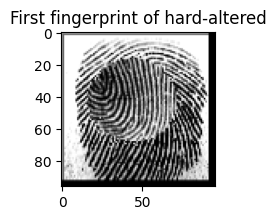

In [6]:
#printing the first fingerprint of hard altered folder
plt.figure(figsize=(2, 2))
plt.title("First fingerprint of hard-altered")
plt.imshow(X_hard[0], cmap='gray')

In [7]:
#separating image values for real data
X_test, y_SubjectID_test, y_fingerNum_test = [], [], []

for SubjectID, fingerNum, feature in Real_data:
    X_test.append(feature)
    y_SubjectID_test.append(SubjectID)
    y_fingerNum_test.append(fingerNum)

X_test = np.array(X_test).reshape(-1, img_size, img_size, 1)
X_test = X_test / 255.0

y_SubjectID_test = to_categorical(y_SubjectID_test, num_classes=600)
y_fingerNum_test = to_categorical(y_fingerNum_test, num_classes=10)

In [8]:
#creating two models including techniques like L2 regularization, batch normalization and dropout to prevent overfitting
nets = 2
model = [0] * nets
final_Dense_units = [600, 10]
model_name = ['SubjectID_Mod', 'FingerNum_Mod']
for i in range(nets):
    model[i] = Sequential(name=model_name[i])

    model[i].add(layers.Conv2D(32, (5, 5), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape = (96, 96, 1)))
    model[i].add(layers.BatchNormalization())
    model[i].add(layers.MaxPool2D((2, 2)))
    model[i].add(layers.Conv2D(64,(5, 5), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model[i].add(layers.BatchNormalization())
    model[i].add(layers.MaxPool2D((2, 2)))
    model[i].add(layers.Conv2D(128,(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model[i].add(layers.BatchNormalization())
    model[i].add(layers.MaxPool2D((2, 2)))
    model[i].add(layers.Dropout(0.3))
    model[i].add(layers.Flatten())
    model[i].add(layers.Dense(256, activation='relu'))
    model[i].add(layers.Dropout(0.4))
    model[i].add(layers.Dense(final_Dense_units[i], activation='softmax'))

    # Complete with Adam optimizer and entropy cost
    model[i].compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])
    model[i].summary()

Model: "SubjectID_Mod"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 92, 92, 32)        832       
                                                                 
 batch_normalization (Batch  (None, 92, 92, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 64)        51264     
                                                                 
 batch_normalization_1 (Bat  (None, 42, 42, 64)        256       
 chNormalization)                                                
                                                     

In [9]:
#fitting the first model for subject ID 
history = [0] * nets
CallBack = [0] * nets
ReduceLR_minlr = [1e-9, 1e-7]
epochs = 15
batch_size = 64
for i in range(nets):
    CallBack[i] = [
        callbacks.EarlyStopping(monitor='val_accuracy', patience=10, mode='max', verbose=1),
        callbacks.ReduceLROnPlateau(factor=0.1, patience=1, min_lr=ReduceLR_minlr[i], verbose=1),
        callbacks.TensorBoard(log_dir="./log_dir/"+model_name[i])]
history[0] = model[0].fit(X_SubjectID_train_hard, y_SubjectID_train_hard,
                    batch_size = batch_size,
                    epochs = epochs, 
                    validation_data = (X_SubjectID_val_hard, y_SubjectID_val_hard),
                    verbose = 1, callbacks= CallBack[0])

Epoch 1/15
201/201 [==============================] - 327s 2s/step - loss: 6.5947 - accuracy: 0.0017 - val_loss: 7.6507 - val_accuracy: 0.0014 - lr: 1.0000e-04
Epoch 2/15
201/201 [==============================] - 318s 2s/step - loss: 6.4980 - accuracy: 0.0037 - val_loss: 7.1808 - val_accuracy: 0.0021 - lr: 1.0000e-04
Epoch 3/15
201/201 [==============================] - 315s 2s/step - loss: 6.4021 - accuracy: 0.0087 - val_loss: 6.4255 - val_accuracy: 0.0063 - lr: 1.0000e-04
Epoch 4/15
201/201 [==============================] - 315s 2s/step - loss: 6.2239 - accuracy: 0.0132 - val_loss: 6.2422 - val_accuracy: 0.0175 - lr: 1.0000e-04
Epoch 5/15
201/201 [==============================] - 382s 2s/step - loss: 5.9820 - accuracy: 0.0242 - val_loss: 6.0513 - val_accuracy: 0.0259 - lr: 1.0000e-04
Epoch 6/15
201/201 [==============================] - 324s 2s/step - loss: 5.6093 - accuracy: 0.0505 - val_loss: 5.7939 - val_accuracy: 0.0476 - lr: 1.0000e-04
Epoch 7/15
201/201 [====================

45/45 [==============================] - 14s 282ms/step


C:\Users\Pita\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\Pita\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\Pita\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\Pita\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\Pita\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1132: UndefinedMetri

C:\Users\Pita\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\Pita\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\Pita\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\Pita\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\Pita\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1132: UndefinedMetri

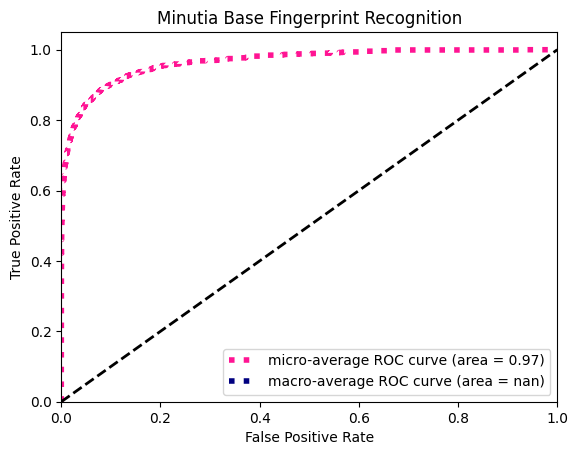

In [10]:
#ROC, AUC curves to show performance of the model
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp


y_score = model[0].predict(X_SubjectID_val_hard)
y_test = y_SubjectID_val_hard
n_classes = y_test.shape[1]
# y_SubjectID_val

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
# Plot all ROC curves
lw=2
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

# colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
# for i, color in zip(range(n_classes), colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#              label='ROC curve of class {0} (area = {1:0.2f})'
#              ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Minutia Base Fingerprint Recognition')
plt.legend(loc="lower right")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.9546965452847805

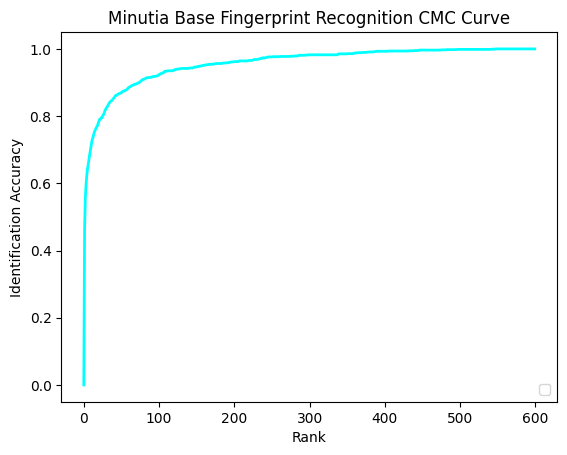

In [11]:
#CMC curve to analyse model performance
# Acc
(np.argmax(y_score, axis=1) == np.argmax(y_test, axis=1)).sum()/y_score.shape[0]

# CMC
rank = np.argsort(y_score,axis=1)[:,::-1]
label = np.argmax(y_test, axis=1)

cmc_curve = np.zeros(n_classes)
for k in range(n_classes):
    for i in range(len(label)): 
        if label[i] in rank[i,:k]:
            cmc_curve[k] += 1
    cmc_curve[k] /= len(label)


plt.plot(np.array(range(600)), cmc_curve, color='aqua', lw=lw,
          label='')
plt.xlabel('Rank')
plt.ylabel('Identification Accuracy')
plt.title('Minutia Base Fingerprint Recognition CMC Curve')
plt.legend(loc="lower right")
plt.legend(loc="lower right")

auc(np.array(range(600))/600, cmc_curve)

In [11]:

history = [0] * nets
CallBack = [0] * nets
ReduceLR_minlr = [1e-9, 1e-7]
epochs = 15
batch_size = 64
for i in range(nets):
    CallBack[i] = [
        callbacks.EarlyStopping(monitor='val_accuracy', patience=10, mode='max', verbose=1),
        callbacks.ReduceLROnPlateau(factor=0.1, patience=1, min_lr=ReduceLR_minlr[i], verbose=1),
        callbacks.TensorBoard(log_dir="./log_dir/"+model_name[i])]#fitting the second model for fingername
history[1] = model[1].fit(X_fingerNum_train_hard, y_fingerNum_train_hard,
                    batch_size = batch_size,
                    epochs = epochs, 
                    validation_data = (X_fingerNum_val_hard, y_fingerNum_val_hard),
                    verbose = 1, callbacks= CallBack[1])

Epoch 1/15
179/179 [==============================] - 384s 2s/step - loss: 2.2734 - accuracy: 0.2852 - val_loss: 4.2240 - val_accuracy: 0.1569 - lr: 1.0000e-04
Epoch 2/15
179/179 [==============================] - 302s 2s/step - loss: 1.7330 - accuracy: 0.4254 - val_loss: 3.4861 - val_accuracy: 0.1944 - lr: 1.0000e-04
Epoch 3/15
179/179 [==============================] - 296s 2s/step - loss: 1.5277 - accuracy: 0.5013 - val_loss: 1.7063 - val_accuracy: 0.4319 - lr: 1.0000e-04
Epoch 4/15
179/179 [==============================] - 295s 2s/step - loss: 1.3727 - accuracy: 0.5536 - val_loss: 1.3405 - val_accuracy: 0.5723 - lr: 1.0000e-04
Epoch 5/15
179/179 [==============================] - 292s 2s/step - loss: 1.2434 - accuracy: 0.5984 - val_loss: 1.2965 - val_accuracy: 0.5751 - lr: 1.0000e-04
Epoch 6/15
179/179 [==============================] - 291s 2s/step - loss: 1.1166 - accuracy: 0.6444 - val_loss: 1.1533 - val_accuracy: 0.6329 - lr: 1.0000e-04
Epoch 7/15
179/179 [====================

AttributeError: 'int' object has no attribute 'history'

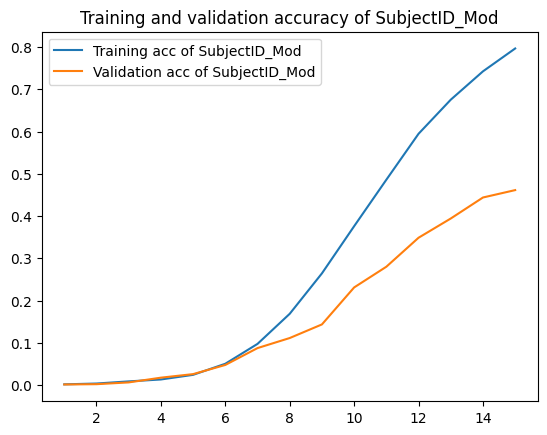

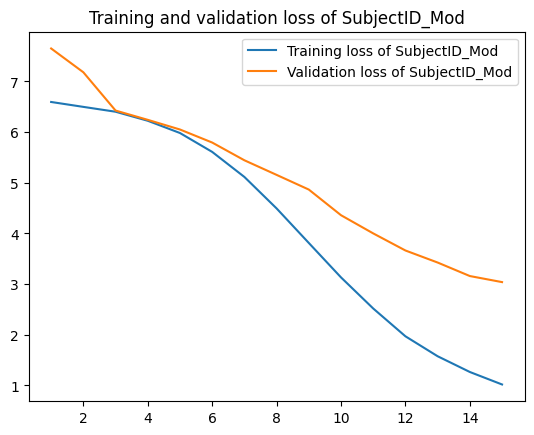

In [12]:
#plotting training and validation accuracy and loss for both models
%matplotlib inline

acc = [0] * nets
val_acc = [0] * nets
loss = [0] * nets
val_loss = [0] * nets
for i in range(nets):
    acc[i] = history[i].history['accuracy']
    val_acc[i] = history[i].history['val_accuracy']
    loss[i] = history[i].history['loss']
    val_loss[i] = history[i].history['val_loss']

    epochs = range(1, len(acc[i]) + 1)
    # plot figures models
    plt.figure()
    plt.plot(epochs, acc[i], label='Training acc of '+model_name[i])
    plt.plot(epochs, val_acc[i], label='Validation acc of '+model_name[i])
    plt.title('Training and validation accuracy of '+model_name[i])
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss[i],  label='Training loss of '+model_name[i])
    plt.plot(epochs, val_loss[i], label='Validation loss of '+model_name
[i])
    plt.title('Training and validation loss of '+model_name[i])
    plt.legend()

testing_acc_Id = model[0].evaluate([X_test], [y_SubjectID_test], verbose=0)
print("Id recognition accuracy: ",testing_acc_Id[1]*100, "%")
testing_acc_finger = model[1].evaluate([X_test], [y_fingerNum_test], verbose=0)
print("Finger recognition accuracy: ",testing_acc_finger[1]*100, "%")

188/188 [==============================] - 42s 197ms/step
Evaluation Report:
              precision    recall  f1-score   support

           0       0.72      0.84      0.78       600
           1       0.79      0.75      0.77       600
           2       0.83      0.77      0.80       600
           3       0.81      0.82      0.81       600
           4       0.95      0.95      0.95       600
           5       0.81      0.82      0.81       600
           6       0.82      0.77      0.79       600
           7       0.85      0.79      0.82       600
           8       0.84      0.91      0.87       600
           9       0.98      0.97      0.97       600

    accuracy                           0.84      6000
   macro avg       0.84      0.84      0.84      6000
weighted avg       0.84      0.84      0.84      6000



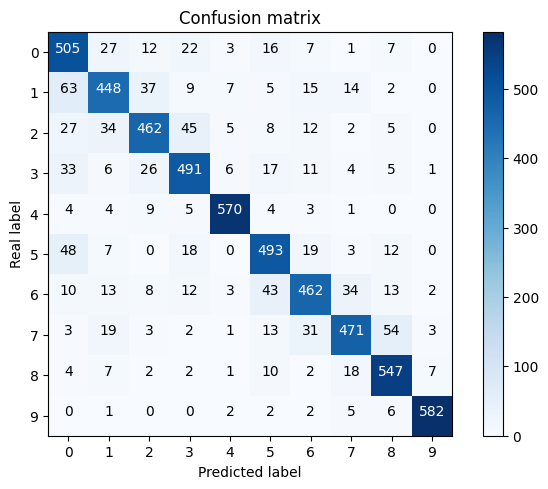

In [24]:
#Confusion matrix and classification report for evaluation of the fingername model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
# Visualize finger prediction with confusion matrix 
def plot_confusion_matrix(conmat, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(conmat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        conmat = conmat.astype('float') / conmat.sum(axis=1)[:, np.newaxis]

    thresh = conmat.max() / 2.
    for i, j in itertools.product(range(conmat.shape[0]), range(conmat.shape[1])):
        plt.text(j, i, conmat[i, j],
                 horizontalalignment="center",
                 color="white" if conmat[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Real label')
    plt.xlabel('Predicted label')

# Predict the values from the test dataset
y_fingerNum_pred_hard = model[1].predict(X_test)
# Convert predictions classes to one hot vectors 
y_fingerNum_pred_classes = np.argmax(y_fingerNum_pred_hard, axis=1) 
# Convert test observations to one hot vectors
y_fingerNum_real = np.argmax(y_fingerNum_test, axis=1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_fingerNum_real, y_fingerNum_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 
#Generate the evaluation report
report = classification_report(y_fingerNum_real, y_fingerNum_pred_classes)
print("Evaluation Report:")
print(report)




In [32]:
#trying to improve model performance using augumentation but actually became worse
from keras.preprocessing.image import ImageDataGenerator

# Create data augmentation generators
datagen_subject_id = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

#fitting the first model for subject ID 
history = [0] * nets
CallBack = [0] * nets
ReduceLR_minlr = [1e-9, 1e-7]
epochs = 15
batch_size = 64
for i in range(nets):
    CallBack[i] = [
        callbacks.EarlyStopping(monitor='val_accuracy', patience=10, mode='max', verbose=1),
        callbacks.ReduceLROnPlateau(factor=0.1, patience=1, min_lr=ReduceLR_minlr[i], verbose=1),
        callbacks.TensorBoard(log_dir="./log_dir/"+model_name[i])]
history[0] = model[0].fit(
                    datagen_subject_id.flow(X_SubjectID_train_hard, y_SubjectID_train_hard,
                    batch_size = batch_size),
                    epochs = epochs, 
                    validation_data = (X_SubjectID_val_hard, y_SubjectID_val_hard),
                    verbose = 1, callbacks= CallBack[0])






Epoch 1/15
179/179 [==============================] - 535s 2s/step - loss: 6.6262 - accuracy: 0.0024 - val_loss: 7.8471 - val_accuracy: 0.0014 - lr: 1.0000e-04
Epoch 2/15
179/179 [==============================] - 346s 2s/step - loss: 6.5325 - accuracy: 0.0025 - val_loss: 7.0689 - val_accuracy: 0.0018 - lr: 1.0000e-04
Epoch 3/15
179/179 [==============================] - 336s 2s/step - loss: 6.5212 - accuracy: 0.0021 - val_loss: 6.5142 - val_accuracy: 0.0018 - lr: 1.0000e-04
Epoch 4/15
179/179 [==============================] - 333s 2s/step - loss: 6.5097 - accuracy: 0.0029 - val_loss: 6.5072 - val_accuracy: 0.0014 - lr: 1.0000e-04
Epoch 5/15
179/179 [==============================] - ETA: 0s - loss: 6.4899 - accuracy: 0.0031
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
179/179 [==============================] - 337s 2s/step - loss: 6.4899 - accuracy: 0.0031 - val_loss: 6.5079 - val_accuracy: 0.0014 - lr: 1.0000e-04
Epoch 6/15
179/179 [===================